In [1]:
import tensorflow as tf
import matplotlib
import cv2

from tensorflow.keras import applications, preprocessing, utils

from src.Objective import Objective
from src.Parameterization import Parameterization
from src.Transformation import *
from src.Regularizer import *
from src.Optimizer import *
from src.Miscellaneous import load_image
from src.Attribution import *
from src.Wrapper import *



print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = Wrapper('InceptionV3')

print(model.layers())

['input_1', 'conv2d', 'batch_normalization', 'activation', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'max_pooling2d', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'max_pooling2d_1', 'conv2d_8', 'batch_normalization_8', 'activation_8', 'conv2d_6', 'conv2d_9', 'batch_normalization_6', 'batch_normalization_9', 'activation_6', 'activation_9', 'average_pooling2d', 'conv2d_5', 'conv2d_7', 'conv2d_10', 'conv2d_11', 'batch_normalization_5', 'batch_normalization_7', 'batch_normalization_10', 'batch_normalization_11', 'activation_5', 'activation_7', 'activation_10', 'activation_11', 'mixed0', 'conv2d_15', 'batch_normalization_15', 'activation_15', 'conv2d_13', 'conv2d_16', 'batch_normalization_13', 'batch_normalization_16', 'activation_13', 'activation_16', 'average_pooling2d_1', 'conv2d_12', 'conv2d_14', 'conv2d_17', 'conv2d_18', 'batch_normalization_12', 'batch_normaliza

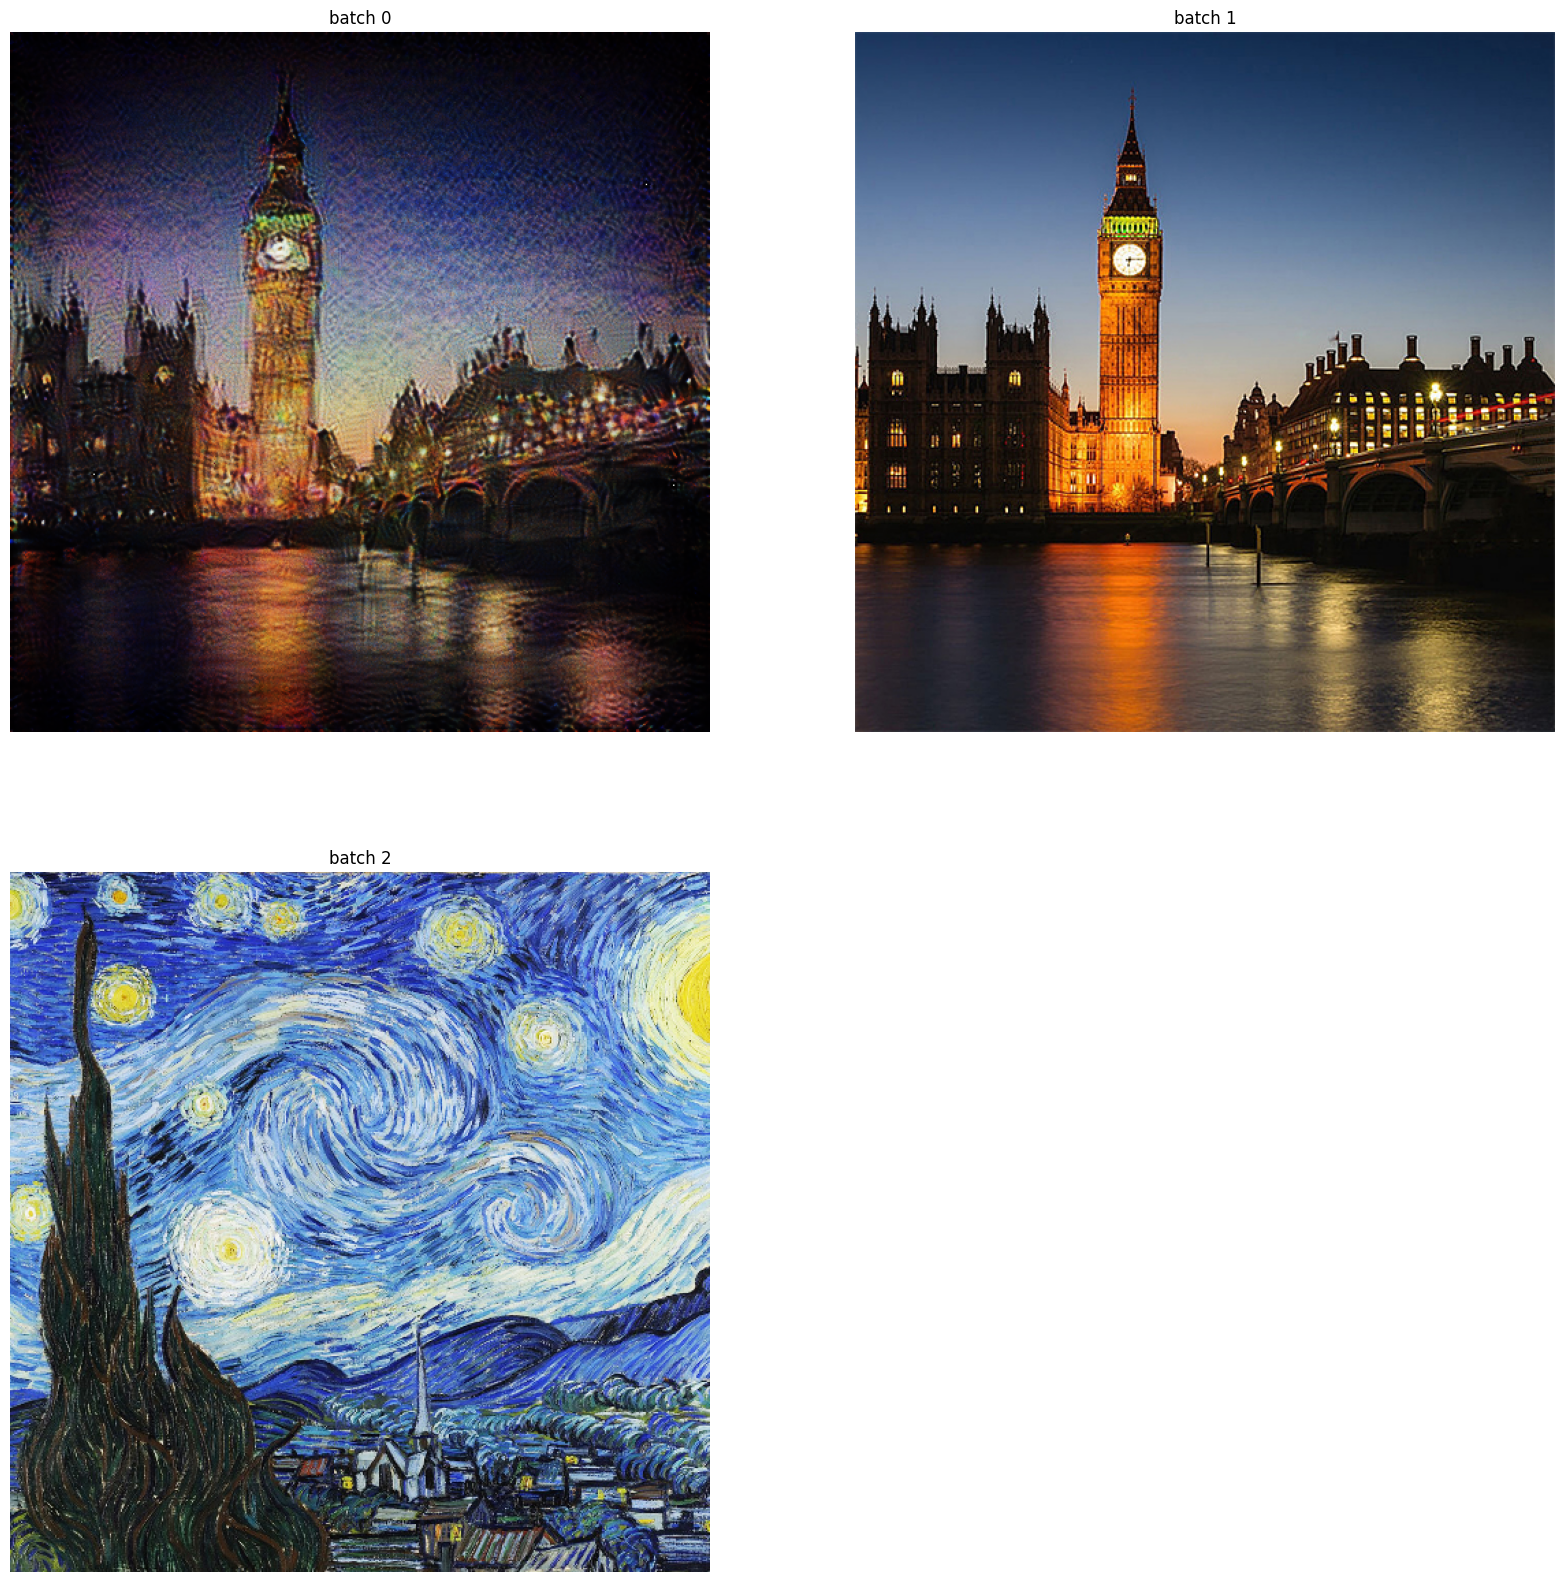

In [3]:
i = 'src\imagenet-examples\london.png'
s = 'src\imagenet-examples\\neural_style_transfer_5_1.jpg'

layers = ['mixed3'] 

style_layers = ['mixed5',
                'mixed7', 
                'mixed9']


images = run_style_transfer(i, s, model,
                            layers, style_layers,
                            steps = 1000, 
                            verbose = False)

plot_all(images)